In [1]:
import numpy as np
import pandas as pd
from scipy.special import logit, expit
from scipy.stats import bernoulli
from matplotlib import pyplot as plt
import pymc as pm
import arviz as az

In [2]:
hoyle_data = pd.read_csv("data/hoyle_automated_2021.csv", header=0)

# Removing auto measures
auto_measures = [c for c in hoyle_data.columns if c[:2] == "c_"] + ["u_mass_full"]
hoyle_data = hoyle_data.drop(columns = auto_measures)
hoyle_data.head(5).T

# Subsetting by intrusion task
d = hoyle_data[hoyle_data["task"]=="intrusions"].drop(columns="task")

# Adding index to join samples on
d.loc[:, "s_dim_0"] = range(len(d))

In [3]:
## Creating unique identifier for each topic

unique_topic_ids = (d.groupby(["dataset", "model", "topic_idx"], as_index=False)
    .agg({"scores_raw":"count"})
    .drop(columns="scores_raw"))

unique_topic_ids["m_topic"] = unique_topic_ids.index

d1 = pd.merge(d, unique_topic_ids, on=["dataset", "model", "topic_idx"], how="left")

In [4]:
# Setting up numpy arrays for pymc
topics = np.array(d1["m_topic"])
n_topics = d1["m_topic"].nunique()
scores = np.array(d1["scores_raw"])

In [123]:
t_only_model = pm.Model()
with t_only_model:
    # Setting topic log odd prior to be N(0,1.5)
    mu_a = pm.Normal("mu_a", mu=0, sigma=1.5)
    sigma_a = pm.Exponential("sigma_a", lam=2) 
    
    a = pm.Normal("a", mu=mu_a, sigma=sigma_a, shape=n_topics)
    p = pm.math.invlogit(a[topics])
    
    # Likelihood is Bernoulli
    s = pm.Bernoulli("s", p=p, observed=scores)
    

    t_trace=pm.sample(cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


In [124]:
with t_only_model:
    t_prior=pm.sample_prior_predictive(1_000)
    t_posterior = pm.sample_posterior_predictive(t_trace)

[]

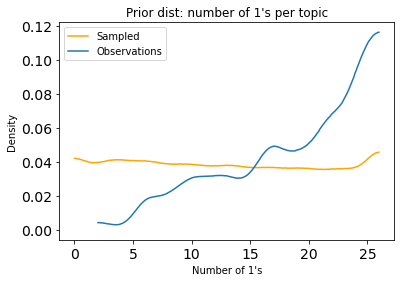

In [125]:
prior=t_prior

samples_df = prior.prior_predictive.sel(chain=0)
target = "s"

# Manipulating samples to plot
df_prior = samples_df[target].to_dataframe()
pos_of_draw = list(df_prior.index.names).index("draw")
df_prior["draw"] = df_prior.index.get_level_values(pos_of_draw)

# Joining rater/topic/model/corpus information
df_prior1 = pd.merge(df_prior, d1, on=target+"_dim_0", how="left")

# Aggregating "1" counts by topic
sample_agg = df_prior1.groupby(["draw", "m_topic"]).agg({target:"sum"})
obs_agg = df_prior1[df_prior1["chain"]==0].groupby(["draw", "m_topic"]).agg({"scores_raw":"sum"})


# Setting up plot
_, ax = plt.subplots(1, 1)
ax = az.plot_kde(np.array(sample_agg[target]), bw=1)
ax.get_lines()[0].set_color("orange")
ax = az.plot_kde(np.array(obs_agg["scores_raw"]), bw=1)
ax.set_title("Prior dist: number of 1's per topic")
ax.set_ylabel("Density")
ax.set_xlabel("Number of 1's")
ax.legend(ax.get_lines(), ["Sampled", "Observations"])
plt.plot()

[]

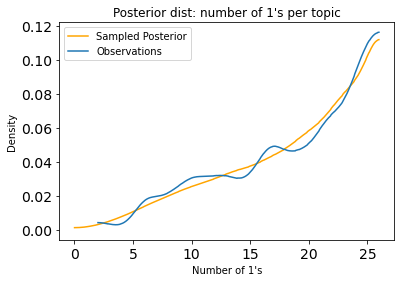

In [126]:
posterior = t_posterior
samples_df = posterior.posterior_predictive.sel(chain=0)
target = "s"

# Manipulating samples to plot
df_posterior = samples_df[target].to_dataframe()
pos_of_draw = list(df_posterior.index.names).index("draw")
df_posterior["draw"] = df_posterior.index.get_level_values(pos_of_draw)

# Joining rater/topic/model/corpus information
df_posterior1 = pd.merge(df_posterior, d1, on=target+"_dim_0", how="left")

# Aggregating "1" counts by topic
sample_agg = df_posterior1.groupby(["draw", "m_topic"]).agg({target:"sum"})
obs_agg = df_posterior1[df_posterior1["chain"]==0].groupby(["draw", "m_topic"]).agg({"scores_raw":"sum"})

# Setting up plot
_, ax = plt.subplots(1, 1)
ax = az.plot_kde(np.array(sample_agg[target]), bw=1)
ax.get_lines()[0].set_color("orange")
ax = az.plot_kde(np.array(obs_agg["scores_raw"]), bw=1)
ax.set_title("Posterior dist: number of 1's per topic")
ax.set_ylabel("Density")
ax.set_xlabel("Number of 1's")
ax.legend(ax.get_lines(), ["Sampled Posterior", "Observations"])
plt.plot()

In [91]:
# Divergent transitions
pd.DataFrame(t_trace.sample_stats["diverging"]).T.sum(axis="rows")

0    0
1    0
2    0
3    0
dtype: int64

===================================== Trace diagnostics =====================================
Divergent transitions
0    0
1    0
2    0
3    0
dtype: int64


Vars with highest rhat
            a
147  1.009770
69   1.006440
1    1.005464
248  1.004655
265  1.004331


5 variables with lowest effective sample size
               a
19   3022.539942
244  3159.041715
240  3254.036667
179  3265.371058
41   3310.605005


[]

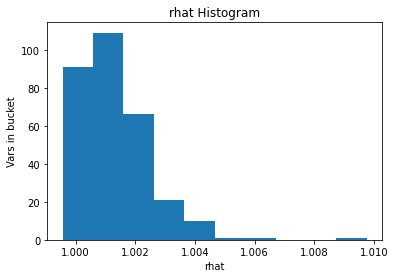

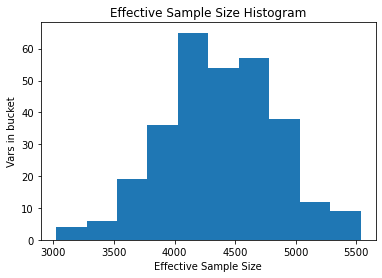

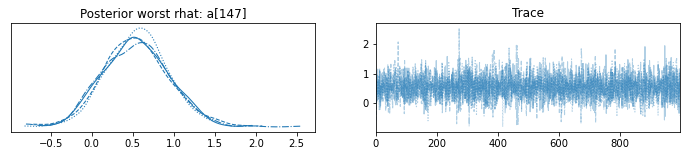

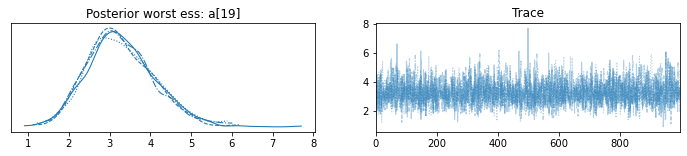

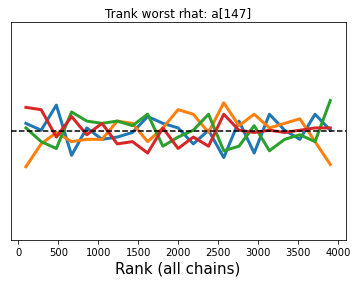

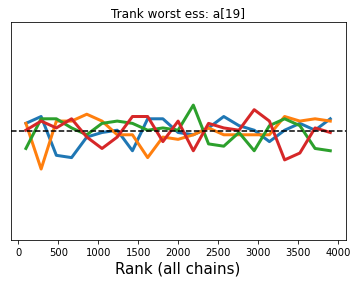

In [109]:
param = "a"

rhat = pd.DataFrame(az.rhat(t_trace)[param], columns=[param]).sort_values(by=param, ascending=False)[:5]
worst_rhat = rhat.index[0]
ess = pd.DataFrame(az.ess(t_trace)[param], columns=[param]).sort_values(by=param)[:5]
worst_ess = ess.index[0]


print("===================================== Trace diagnostics =====================================")
print("Divergent transitions")
print(pd.DataFrame(t_trace.sample_stats["diverging"]).T.sum(axis="rows"))
print("\n")
print("Vars with highest rhat")
print(rhat)
print("\n")
print("5 variables with lowest effective sample size")
print(ess)

# Rhat Histogram
fig1 = plt.figure(1)
ax1 = fig1.add_subplot()
ax1.hist(az.rhat(t_trace)[param])
ax1.set_title("rhat Histogram")
ax1.set_xlabel("rhat")
ax1.set_ylabel("Vars in bucket")

# ESS histogram
fig2 = plt.figure(2)
ax2 = fig2.add_subplot()
ax2.hist(az.ess(t_trace)[param])
ax2.set_title("Effective Sample Size Histogram")
ax2.set_xlabel("Effective Sample Size")
ax2.set_ylabel("Vars in bucket")

# Trace of worst rhat
ax3 = az.plot_trace(t_trace.posterior[param].sel(**{param+"_dim_0":worst_rhat}))
ax3[0][0].set_title(f"Posterior worst rhat: {param}[{worst_rhat}]")
ax3[0][1].set_title("Trace")

# Trace of worst ess
ax4 = az.plot_trace(t_trace.posterior[param].sel(**{param+"_dim_0":worst_ess}))
ax4[0][0].set_title(f"Posterior worst ess: {param}[{worst_ess}]")
ax4[0][1].set_title("Trace")

# Trank of worst rhat
ax5 = az.plot_rank(t_trace.posterior[param].sel(**{param+"_dim_0":worst_rhat}),kind="vlines",
             vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3})
ax5.set_title(f"Trank worst rhat: {param}[{worst_rhat}]")

# Trank of worst ESS
ax6 = az.plot_rank(t_trace.posterior[param].sel(**{param+"_dim_0":worst_ess}),kind="vlines",
             vlines_kwargs={'lw':0}, marker_vlines_kwargs={'lw':3})
ax6.set_title(f"Trank worst ess: {param}[{worst_ess}]")

plt.plot()